# Exercise 5.1 

## Import Libraries
Python requires importing libraries and functions you need to access specific tools like science (scipy), linear algebra (numpy), and graphics (matplotlib). These libraries can be installed using the ```pip``` command line tool. Alternatively you can install an python distribution like [Anaconda](https://www.continuum.io/downloads) or [Canopy](https://www.enthought.com/products/canopy/)  which have these and many other standard package pre-installed.

In [1]:
import ipywidgets as widgets  # add new widgets
from ipywidgets import interact, interactive, fixed
import os
from IPython.display import display
import numpy as np  # linear algebra / matrices
from skimage.color import label2rgb
from sklearn.metrics import roc_curve, auc  # roc curve tools
from skimage.segmentation import mark_boundaries  # mark labels
from skimage.io import imread  # read in images
import matplotlib.pyplot as plt  # plotting
%matplotlib inline
# make the notebook interactive

In [2]:
base_path = '../04-Segmentation/04-files'
seg_path = os.path.join(base_path, 'DogVsMuffin_seg_bw.jpg')
rgb_path = os.path.join(base_path, 'DogVsMuffin.jpg')
face_path = os.path.join(base_path, 'DogVsMuffin_face.jpg')
seg_img = imread(seg_path)[80:520:2, :450:2]
rgb_img = imread(rgb_path)[80:520:2, :450:2, :]
face_img = imread(face_path)
print('RGB Size', rgb_img.shape, 'Seg Size',
      seg_img.shape, 'Face Size', face_img.shape)

RGB Size (220, 225, 3) Seg Size (220, 225) Face Size (111, 131, 3)


Text(0.5, 1.0, 'Labeled Image')

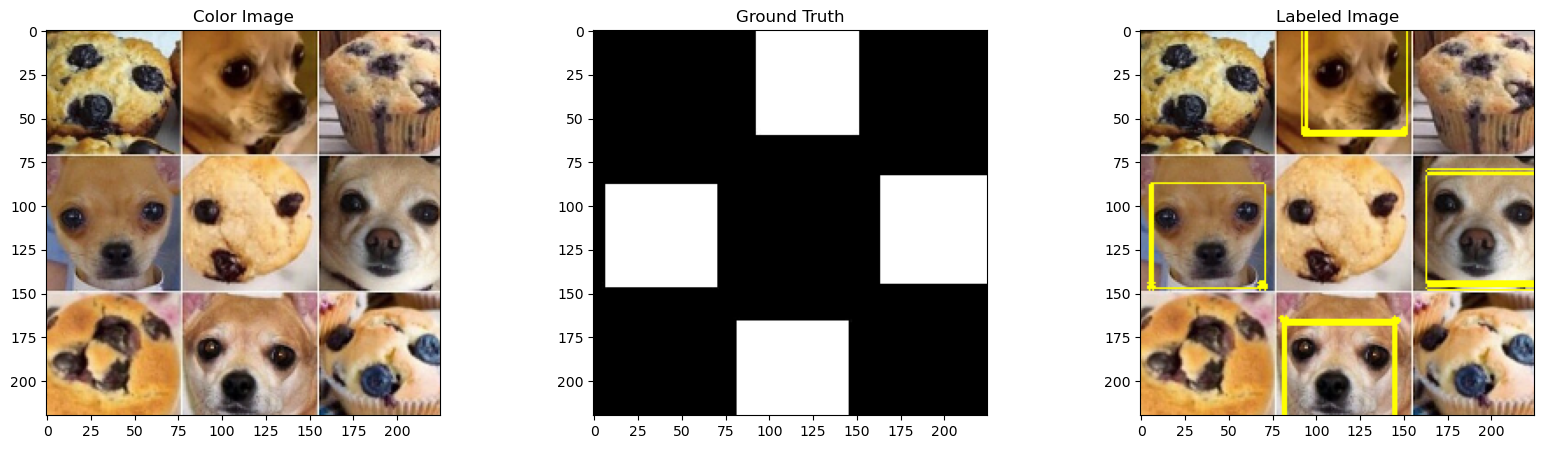

In [3]:
%matplotlib inline
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))
ax1.imshow(rgb_img)  # show the color image
ax1.set_title("Color Image")
ax2.imshow(seg_img, cmap='gray')  # show the segments
ax2.set_title("Ground Truth")
ax3.imshow(mark_boundaries(rgb_img, seg_img))
ax3.set_title("Labeled Image")

## Creating a Simple ROC Curve
We use the score function of taking the mean of the red green and blue channels
$$ I = \frac{R+G+B}{3} $$
We then take the score by normalizing by the maximum value (since the image is 8bit this is 255)
$$ s = \frac{I}{255} $$

Basically, our segmentation is based on the mean intensity value of the 3 RGB channels.

In [4]:
ground_truth_labels = seg_img.flatten() > 0
score_value = 1-np.mean(rgb_img.astype(np.float32), 2).flatten()/255.0
fpr, tpr, _ = roc_curve(ground_truth_labels, score_value)
roc_auc = auc(fpr, tpr)

Text(0.5, 1.0, 'Score values')

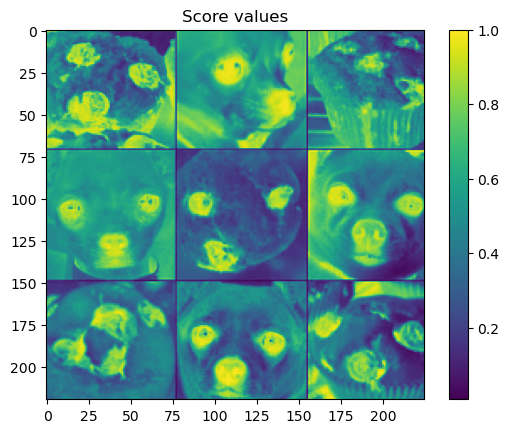

In [5]:
plt.imshow(score_value.reshape(rgb_img.shape[:2]))
plt.colorbar()
plt.title("Score values")


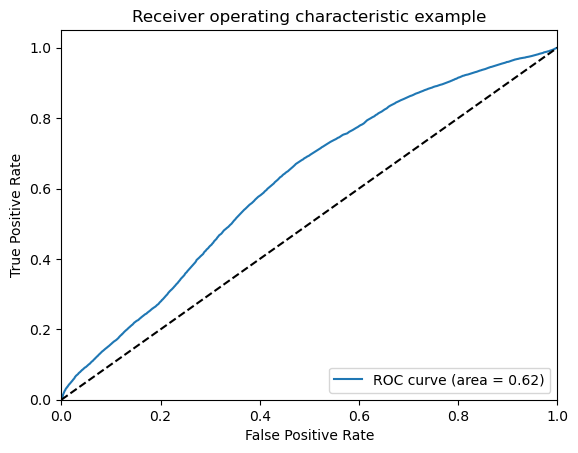

In [6]:
%matplotlib inline
fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

## Adding Filters
We can add a filter to this process by importing a ```uniform_filter``` and applying it before processing the image


Text(0.5, 1.0, 'Score values')

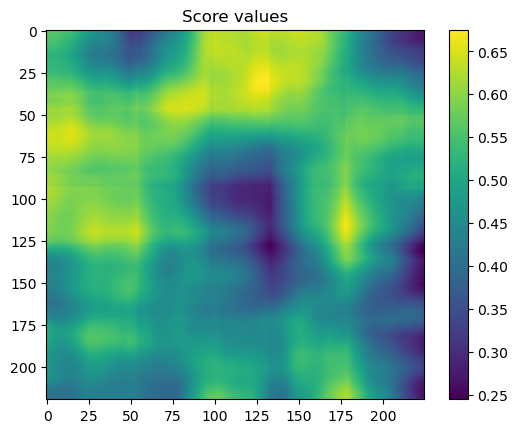

In [7]:
from scipy.ndimage.filters import uniform_filter
%matplotlib inline
filter_size = 45
filtered_image = uniform_filter(np.mean(rgb_img, 2), filter_size)
score_value = 1-filtered_image.astype(np.float32).flatten()/255.0
fpr2, tpr2, _ = roc_curve(ground_truth_labels, score_value)
roc_auc2 = auc(fpr2, tpr2)
plt.imshow(score_value.reshape(rgb_img.shape[:2]))
plt.colorbar()
plt.title("Score values")

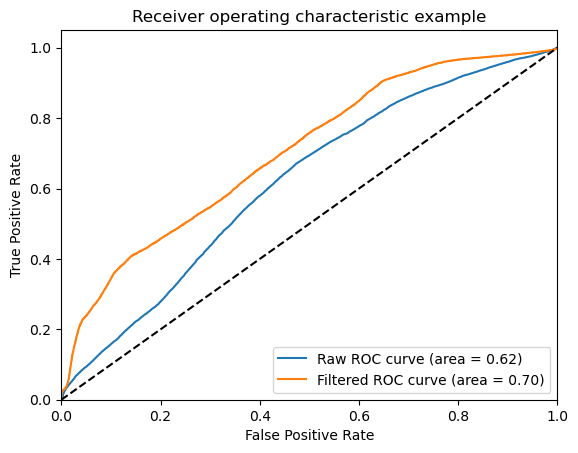

In [8]:

fig, ax = plt.subplots(1, 1)
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fpr2, tpr2, label='Filtered ROC curve (area = %0.2f)' % roc_auc2)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

### Linear optimization

In the example above, we averaged the intensity values of the 3 RGB channles of the image. But we can find a linear combination of the channels that yield better result. To do this we will be using the `scipy.optimize` module ([Docs](https://docs.scipy.org/doc/scipy/reference/optimize.html)). 

In summary, you can use different optimization algorithms out of the box. All you need to do is 1) define function to minimize, 2) give an initial value for each of the parameters of the function to minimize.

First, we define the function to minimize. In this case, we minimize the inverse of the area under the curve (AUC), equivalent to maximize the AUC.


In [9]:
from scipy.optimize import fmin


def calc_auc(rv, gv, bv, fsize):
    filter_size = fsize
    gray_image = (rv*rgb_img[:, :, 0]+gv*rgb_img[:, :,
                                                 1]+bv*rgb_img[:, :, 2])/(rv+gv+bv)
    filtered_image = uniform_filter(gray_image, filter_size)
    score_value = 1-filtered_image.astype(np.float32).flatten()/255.0
    fpr2, tpr2, _ = roc_curve(ground_truth_labels, score_value)
    return {'fpr': fpr2, 'tpr': tpr2, 'auc': auc(fpr2, tpr2), 'gimg': gray_image, 'fimg': filtered_image, 'prediction': score_value}

def min_func(initial_guess): return -calc_auc(*initial_guess)['auc']


We define the initial values for the parameters and test the function we defined works well.

In [10]:
init_rv, init_gv, init_bv, init_fsize = [1, 1, 1, 20]
initial_guess = [init_rv, init_gv, init_bv, init_fsize]
min_func(initial_guess)

-0.5702940701872123

We run the optimization algorithm to find the best parameters.

In [11]:
opt_res = fmin(min_func, initial_guess)

Optimization terminated successfully.
         Current function value: -0.800232
         Iterations: 168
         Function evaluations: 322


The optimal parameters for the red, green and channel weights and the filter size are:

In [12]:
opt_res

array([-0.53374547,  3.0933188 , -1.6367314 , 55.09596972])

In [13]:
opt_values = calc_auc(*opt_res)
tprOpt = opt_values['tpr']
fprOpt = opt_values['fpr']
roc_aucOpt = opt_values['auc']
weighted_image = opt_values['gimg']
filtered_image = opt_values['fimg']
predicted_mask = opt_values['prediction'].reshape(rgb_img.shape[:2])

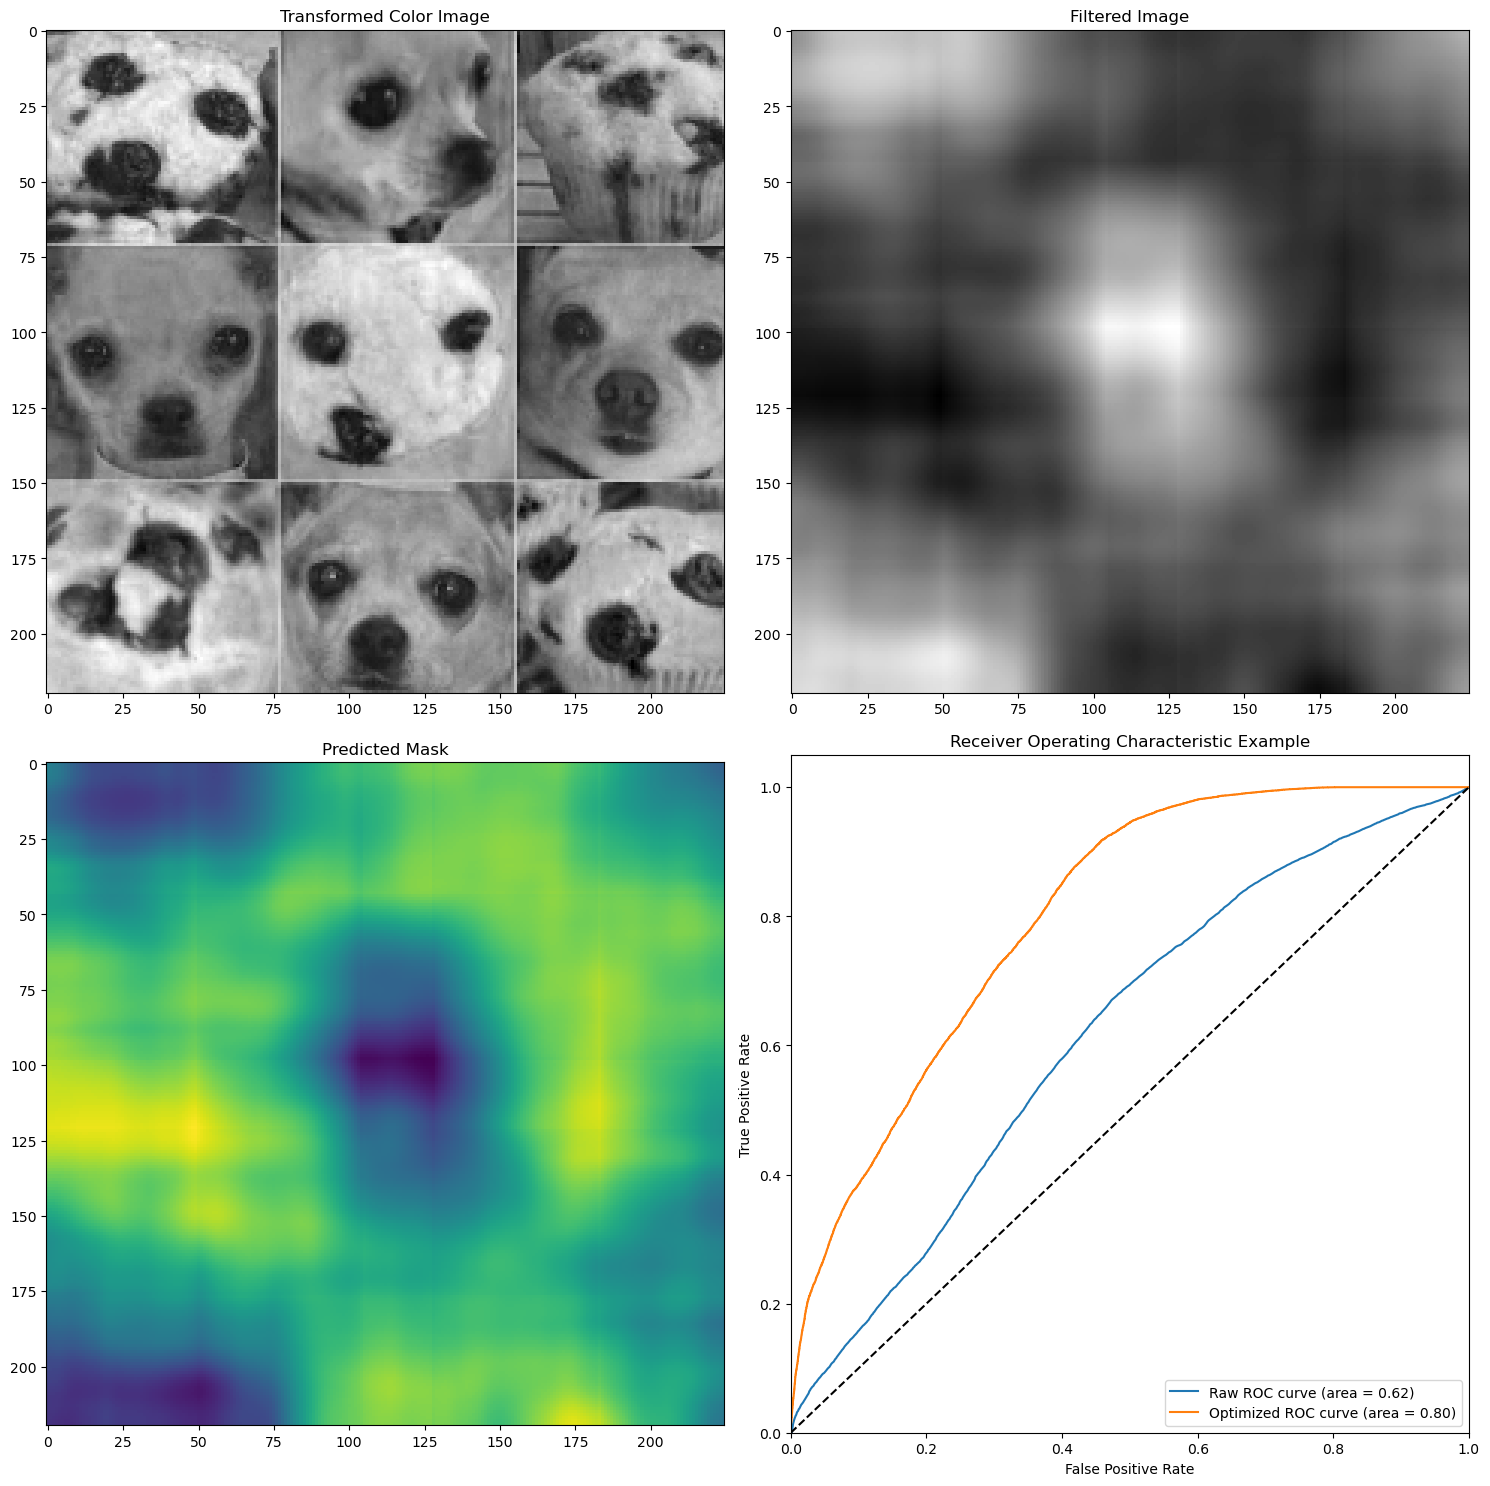

In [14]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Plot weighted image
axes[0][0].imshow(weighted_image, cmap='gray')
axes[0][0].set_title('Transformed Color Image')

# Plot filtered image
axes[0][1].imshow(filtered_image, cmap='gray')
axes[0][1].set_title('Filtered Image')

# Plot predicted mask
axes[1][0].imshow(predicted_mask.reshape(rgb_img.shape[:2]))
axes[1][0].set_title('Predicted Mask')

# Plot ROC curves
ax_roc = axes[1][1]
ax_roc.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax_roc.plot(fprOpt, tprOpt, label='Optimized ROC curve (area = %0.2f)' % roc_aucOpt)
ax_roc.plot([0, 1], [0, 1], 'k--')
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('Receiver Operating Characteristic Example')
ax_roc.legend(loc="lower right")

plt.tight_layout()
plt.show()


#### Some questions to think about:
- What did we achieve with the optimization?
- What is the effect of the filter? What happens if we remove it? (try it!)
- How would you segment a dataset with 10 images?
- How would you segment a dataset with 1M images?
- What are the advantages and disadvantages of this approach?

## Non-linear optimization
Here we use non-linear approaches to improve the quality of the results by introducing a non-linear function into the function we want to minimize. In this case, we will be using a [ReLU](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)). We will also include a bias term we can optimize for each of the RGB channels.

In [26]:
def relu(x):
    return (x+np.abs(x))/2


def calc_auc_nl(red_weight, red_bias, green_weight, green_bias, blue_weight, blue_bias, filter_size):
    gray_image = (red_weight*relu(rgb_img[:, :, 0]/255.0-red_bias)+green_weight*relu(rgb_img[:, :, 1]/255.0-green_bias) +
                  blue_weight*relu(rgb_img[:, :, 2]/255.0-blue_bias))/(red_weight+green_weight+blue_weight)
    filtered_image = uniform_filter(gray_image, filter_size)
    score_value = 1-filtered_image.astype(np.float32).flatten()
    fpr2, tpr2, _ = roc_curve(ground_truth_labels, score_value)
    return {'fpr': fpr2, 'tpr': tpr2, 'auc': auc(fpr2, tpr2), 'gimg': gray_image, 'fimg': filtered_image, 'prediction': score_value}

In [22]:
# Defining the function to minimize
def min_func(args): return -calc_auc_nl(*args)['auc']

# We will use the optimal parameters we found before as the initial values
red_weight_init, green_weight_init, blue_weight_init, filter_size_init = opt_res
red_bias_init, green_bias_init, blue_bias_init = [0, 0, 0]
initial_guess = [red_weight_init, red_bias_init, green_weight_init,
                 green_bias_init, blue_weight_init, blue_bias_init, filter_size_init]
min_func(initial_guess)

-0.8002323517046961

In [23]:
opt_res_nl = fmin(min_func, initial_guess)

Optimization terminated successfully.
         Current function value: -0.816520
         Iterations: 244
         Function evaluations: 450


In [28]:
opt_values_nl = calc_auc_nl(*opt_res_nl)
tprOpt_nl = opt_values_nl['tpr']
fprOpt_nl = opt_values_nl['fpr']
roc_aucOpt_nl = opt_values_nl['auc']

weighted_image = opt_values_nl['gimg']
filtered_image = opt_values_nl['fimg']
predicted_mask = opt_values_nl['prediction'].reshape(rgb_img.shape[:2])

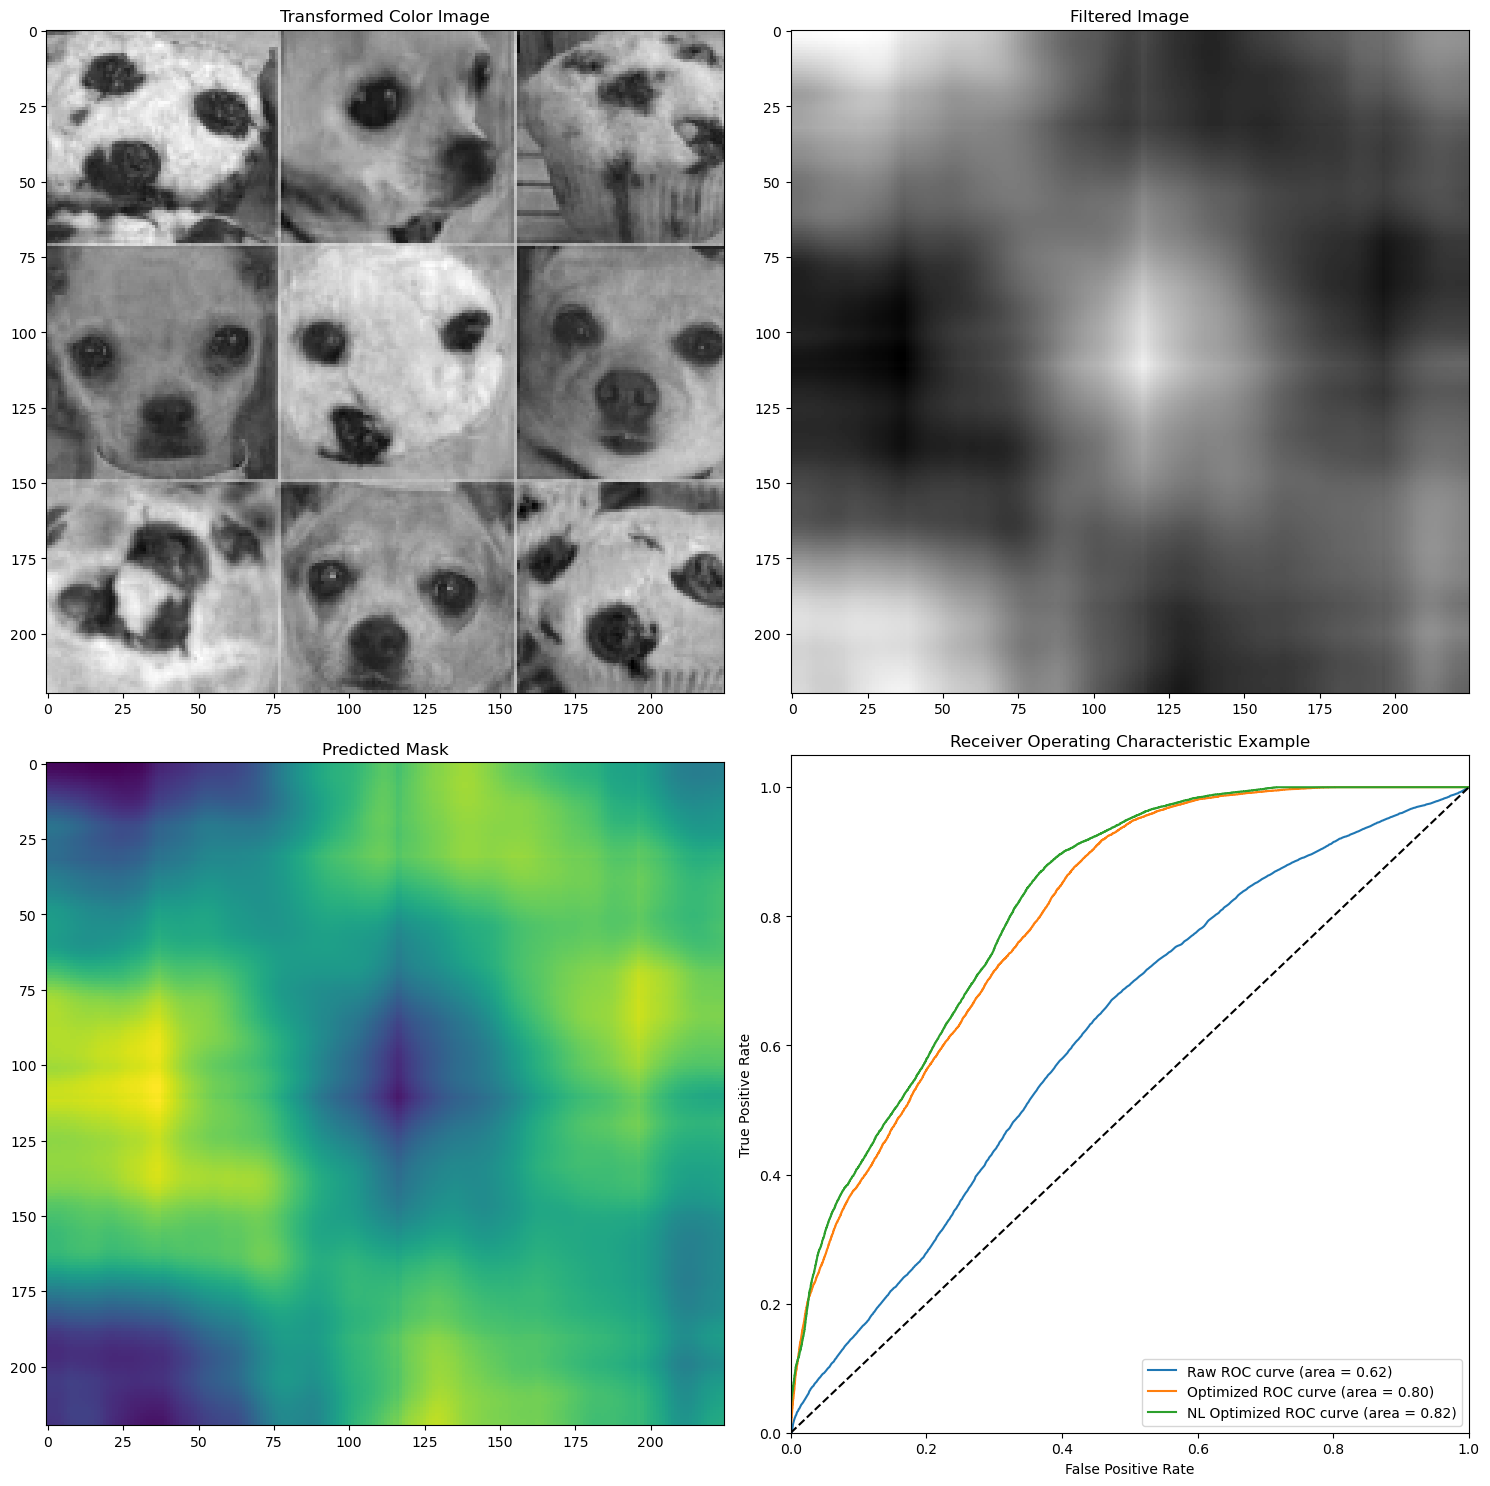

In [29]:
# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

# Plot weighted image
axes[0][0].imshow(weighted_image, cmap='gray')
axes[0][0].set_title('Transformed Color Image')

# Plot filtered image
axes[0][1].imshow(filtered_image, cmap='gray')
axes[0][1].set_title('Filtered Image')

# Plot predicted mask
axes[1][0].imshow(predicted_mask.reshape(rgb_img.shape[:2]))
axes[1][0].set_title('Predicted Mask')

# Plot ROC curves
ax_roc = axes[1][1]
ax_roc.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax_roc.plot(fprOpt, tprOpt, label='Optimized ROC curve (area = %0.2f)' % roc_aucOpt)
ax_roc.plot(fprOpt_nl, tprOpt_nl,
        label='NL Optimized ROC curve (area = %0.2f)' % roc_aucOpt_nl)
ax_roc.plot([0, 1], [0, 1], 'k--')
ax_roc.set_xlim([0.0, 1.0])
ax_roc.set_ylim([0.0, 1.05])
ax_roc.set_xlabel('False Positive Rate')
ax_roc.set_ylabel('True Positive Rate')
ax_roc.set_title('Receiver Operating Characteristic Example')
ax_roc.legend(loc="lower right")

plt.tight_layout()
plt.show()

#### Some questions to think about:
- What did we achieve with the non-linearity in the function we want to optimize?
- How would you segment a dataset with 10 images?
- How would you segment a dataset with 1M images?
- What are the advantages and disadvantages of this approach?

# Next Steps
Rather than simply adjusting basic parameters, we can adjust entire arrays of information. The example below is a simplified [convolutional neural network](https://en.wikipedia.org/wiki/Convolutional_neural_network) with one layer.

In [19]:
from scipy.signal import fftconvolve

def convolve(img1, img2): return fftconvolve(img1, img2, mode='same')


CONV_SIZE = (10, 10, 1)
grey_img = np.reshape(np.mean(rgb_img, 2)/255.0,
                      (rgb_img.shape[0], rgb_img.shape[1], 1))

def calc_auc_conv(rcoefs):
    coefs = rcoefs.reshape(CONV_SIZE)/rcoefs.sum()
    score_image = relu(convolve(grey_img, coefs))
    score_value = 1-score_image.flatten()
    fpr2, tpr2, _ = roc_curve(ground_truth_labels, score_value)
    return {'fpr': fpr2, 'tpr': tpr2, 'auc': auc(fpr2, tpr2), 'gimg': score_image}

## Make a nice gaussian kernel


In [20]:
np.random.seed(2019)
from functools import reduce
def gaussian_kernel_n_dimensional(dimension=2, kernel_length=21, n_sigmas=3, min_smooth_val=1e-2):
    n_sigmas = [n_sigmas] * dimension
    k_wid = (kernel_length - 1) / 2
    all_axs = [np.linspace(-k_wid, k_wid, kernel_length)] * dimension
    all_xxs = np.meshgrid(*all_axs)
    all_dist = reduce(np.add, [
        np.square(cur_xx) / (2 * np.square(np.clip(nsig, min_smooth_val,
                                                   kernel_length)))
        for cur_xx, nsig in zip(all_xxs, n_sigmas)])
    kernel_raw = np.exp(-all_dist)
    return kernel_raw / kernel_raw.sum()

In [21]:
# test the function to make sure it works
def min_func(rcoefs): return 1-calc_auc_conv(rcoefs)['auc']

min_start = gaussian_kernel_n_dimensional(2, CONV_SIZE[0]).ravel()
min_func(min_start)

0.3657458194107146

In [22]:
opt_res_conv = min_start
opt_res_conv = fmin(min_func,
                    opt_res_conv,
                    maxiter=500)

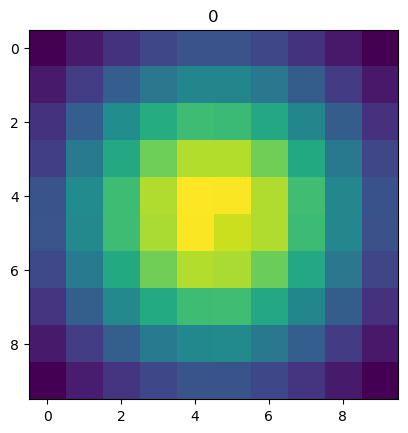

In [23]:
opt_values_conv = calc_auc_conv(opt_res_conv)
tprOpt_conv = opt_values_conv['tpr']
fprOpt_conv = opt_values_conv['fpr']
roc_aucOpt_conv = opt_values_conv['auc']
out_kernel = opt_res_conv.reshape(CONV_SIZE)/opt_res_conv.sum()
fig, ax_all = plt.subplots(1, out_kernel.shape[2])
for i, c_ax in enumerate(np.array(ax_all).flatten()):
    c_ax.imshow(out_kernel[:, :, i])
    c_ax.set_title(str(i))

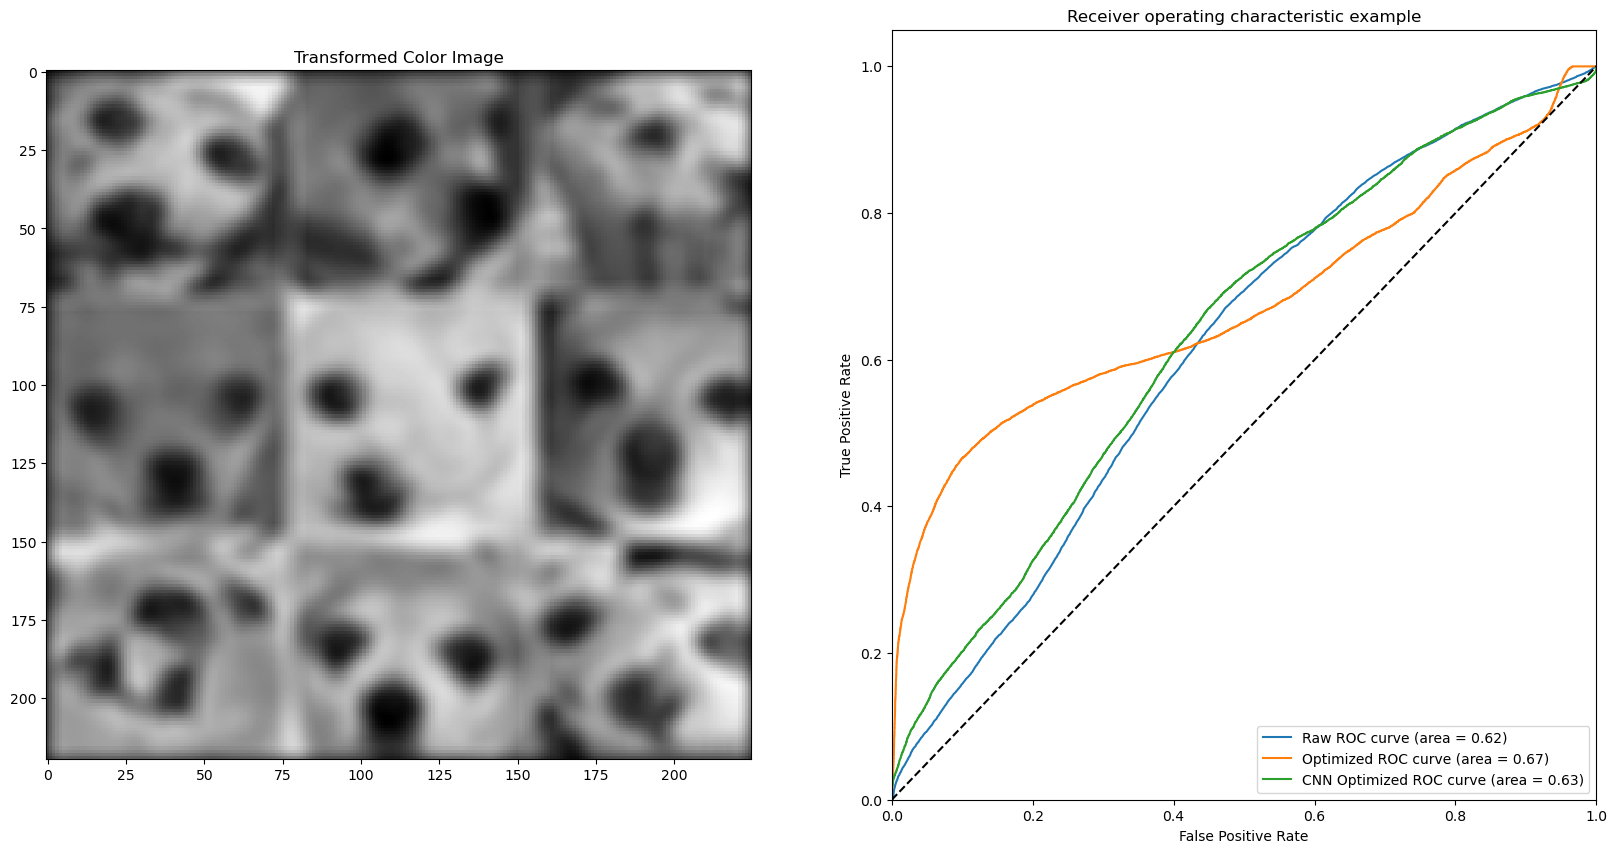

In [24]:
fig, (ax_img, ax) = plt.subplots(1, 2, figsize=(20, 10))
ax_img.imshow(opt_values_conv['gimg'].squeeze(), cmap='gray')
ax_img.set_title('Transformed Color Image')
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fprOpt, tprOpt, label='Optimized ROC curve (area = %0.2f)' % roc_aucOpt)
ax.plot(fprOpt_conv, tprOpt_conv,
        label='CNN Optimized ROC curve (area = %0.2f)' % roc_aucOpt_conv)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

## RGB CNN
Using the RGB instead of the gray value for the CNN

In [42]:
CONV_SIZE = (10, 10, 3)

def calc_auc_conv2d(rcoefs):
    coefs = rcoefs.reshape(CONV_SIZE)/rcoefs.sum()
    score_image = relu(convolve(grey_img, coefs))
    score_value = 1-score_image.flatten()
    fpr2, tpr2, _ = roc_curve(ground_truth_labels, score_value)
    return {'fpr': fpr2, 'tpr': tpr2, 'auc': auc(fpr2, tpr2), 'gimg': score_image}

In [43]:
def min_func(rcoefs): return 1-calc_auc_conv2d(rcoefs)['auc']
min_kernel = np.stack([gaussian_kernel_n_dimensional(2, kernel_length=CONV_SIZE[0])]*3, -1)
min_start = min_kernel.ravel()

In [44]:
opt_res_conv2d = fmin(min_func, min_start, maxfun=500, maxiter=5000)

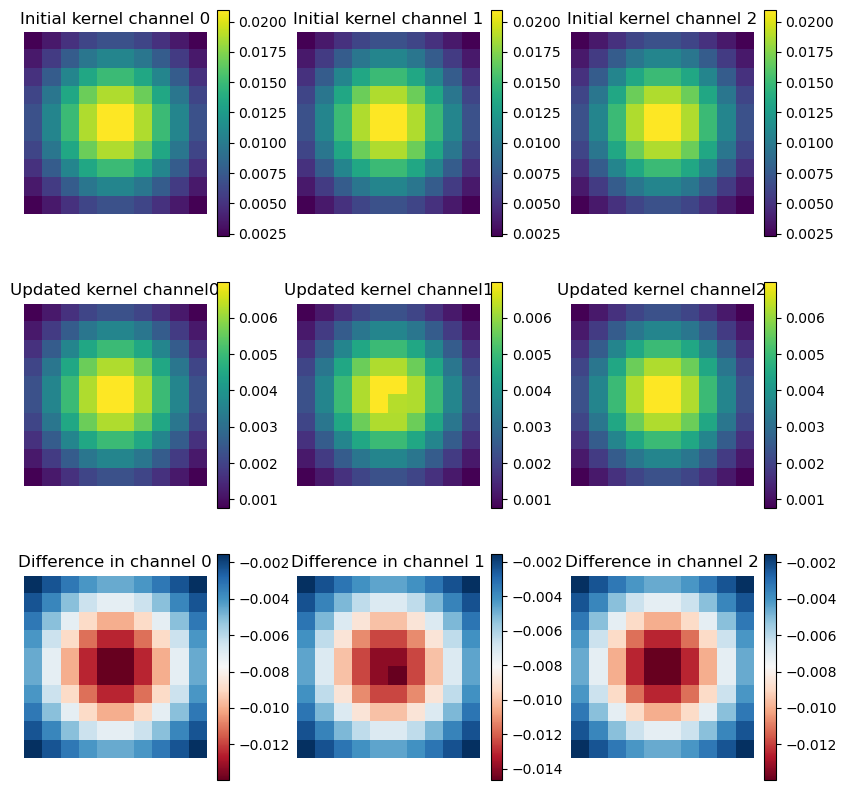

In [45]:
opt_values_conv = calc_auc_conv2d(opt_res_conv2d)
tprOpt_conv = opt_values_conv['tpr']
fprOpt_conv = opt_values_conv['fpr']
roc_aucOpt_conv = opt_values_conv['auc']
out_kernel = opt_res_conv2d.reshape(CONV_SIZE)/opt_res_conv2d.sum()
fig, ax_all = plt.subplots(3, out_kernel.shape[2], figsize=(10, 10))
for i, (c_ax, d_ax, cd_ax) in enumerate(ax_all.T):
    c_im = c_ax.imshow(min_kernel[:, :, i])
    c_ax.set_title('Initial kernel channel {}'.format(i))
    c_ax.axis('off')
    plt.colorbar(c_im, ax=c_ax)
    
    d_im = d_ax.imshow(out_kernel[:, :, i])
    d_ax.set_title('Updated kernel channel{}'.format(i))
    d_ax.axis('off')
    plt.colorbar(d_im, ax=d_ax)
    
    cd_im = cd_ax.imshow(out_kernel[:, :, i]-min_kernel[:, :, i], cmap='RdBu')
    cd_ax.set_title('Difference in channel {}'.format(i))
    cd_ax.axis('off')
    plt.colorbar(cd_im, ax=cd_ax)


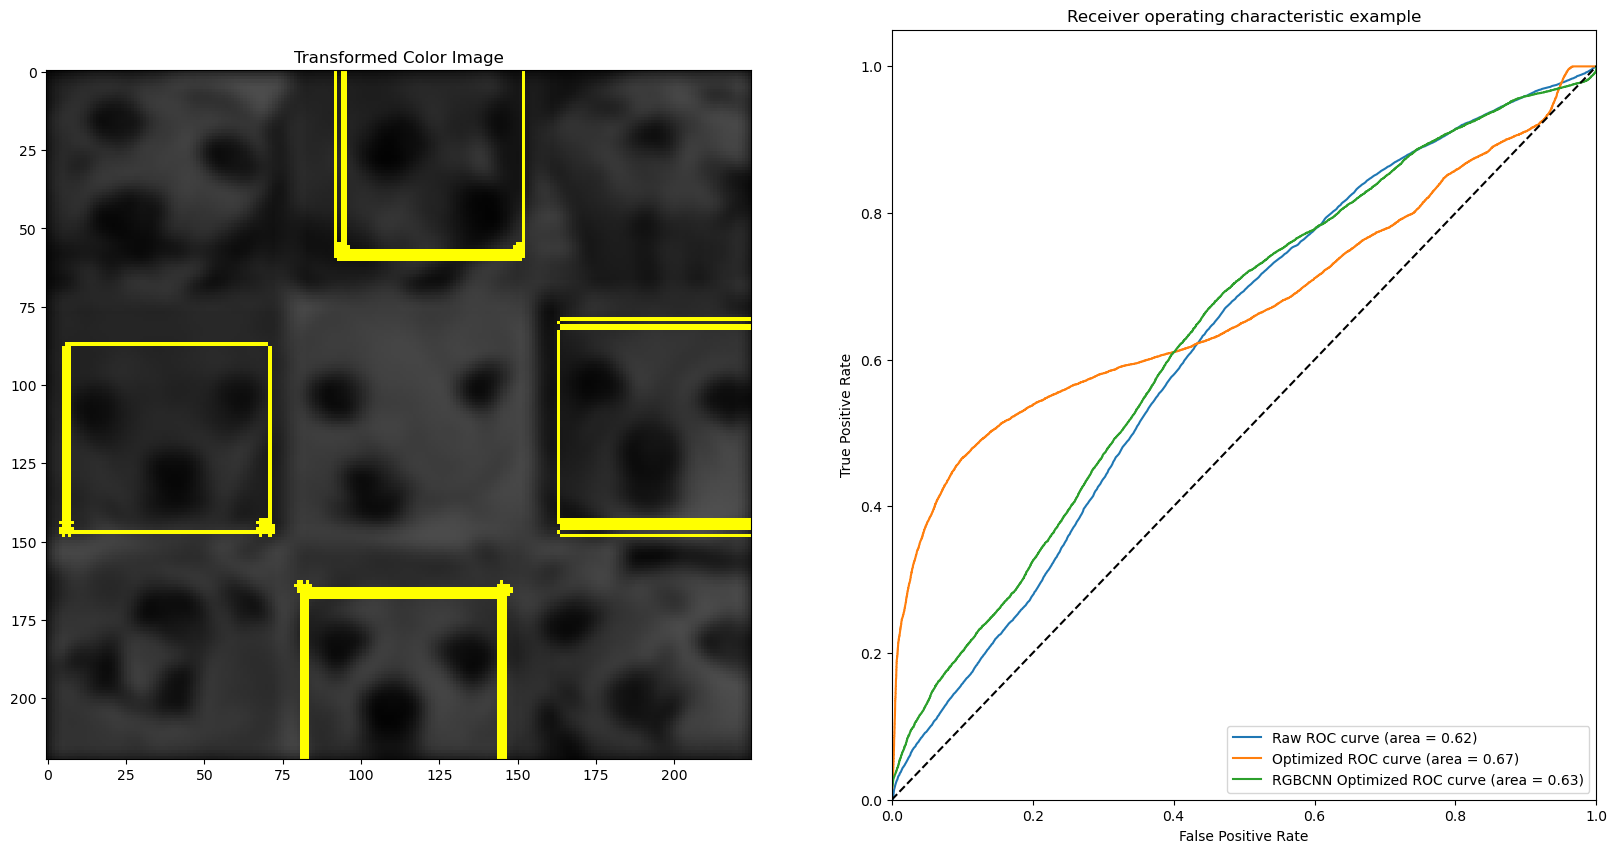

In [46]:
fig, (ax_img, ax) = plt.subplots(1, 2, figsize=(20, 10))
ax_img.imshow(mark_boundaries(
    opt_values_conv['gimg'].squeeze(), seg_img), cmap='gray')
ax_img.set_title('Transformed Color Image')
ax.plot(fpr, tpr, label='Raw ROC curve (area = %0.2f)' % roc_auc)
ax.plot(fprOpt, tprOpt, label='Optimized ROC curve (area = %0.2f)' % roc_aucOpt)
ax.plot(fprOpt_conv, tprOpt_conv,
        label='RGBCNN Optimized ROC curve (area = %0.2f)' % roc_aucOpt_conv)
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Receiver operating characteristic example')
ax.legend(loc="lower right")

### Tasks
1. How can you improve filtering in this analysis? 
 - Which filter elements might improve the area under the ROC?
 - Try making workflows to test out a few different filters
2. Where might morphological operations fit in?
 - How can you make them part of this workflow as well?
3. (Challenge) How would you add multiple filter operations? Can you optimize all of the parameters? What problems do you run into as you make your model more complex?